# Introduction to Landsat pixel quality (PQ25)

**Background:** Data from three Landsat satellites (Landsat 5, 7 and 8) are available to access within DEA. The data can be plotted or analysed after applying selective masks based on pixel quality (PQ25). The code snippets in this doc will let you retrieve the data, mask by using PQ and then plot for `ls*_nbar_albers` and `ls*_nbart_albers`, where `*` is 5, 7 or 8 denote the satellite.

**What does this document do?**

- Show how to open a datacube to retrieve the data for various time points and geo-coordinates
- Extract the PQ data to be used as mask
- Show the description of flags in a table
- Build up a mask step-by-step from PQ data
- Apply the mask and plot

**Requirements**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date**: August 2018

**Authors**: Bex Dunn, Robbi Bishop-Taylor, Mike Barnes, Claire Krause, Damien Ayers, Arapaut Sivaprasad

## Importance of pixel quality

As Landsat Imagery becomes more readily available, there has been a rapid increase in the amount of analyses undertaken by researchers around the globe. In the past, researchers would reject partly cloud-affected scenes in favour of cloud-free scenes. However, Landsat time series analysis using all cloud-free pixels has become a valuable technique and has increased the demand for automation of cloud, cloud shadow and saturation detection. Emergency response applications such as flood mapping typically have to contend with individual cloud affected scenes and therefore rely on effective cloud and cloud shadow removal techniques. The capacity to automatically exclude such pixels is essential for emerging multi-temporal analysis techniques that make use of every quality assured pixel within a time series of observations. [[1](#References)]

## What is PQ25? 

PQ25 is an assessment of each image pixel to determine if it is an unobscured, unsaturated observation of the Earth surface and also whether the pixel is represented in each spectral band. The PQ product allows users to produce masks which can be used to exclude pixels which do not meet their quality criteria from analysis. PQ25 provides an assessment of the quality of observations at a pixel level, and contains information about whether a pixel is affected by the following.

- Spectral Contiguity (lack of signal in any band)
- Saturation in any band
- Presence of cloud
- Presence of cloud shadow
- Being offshore (sea) 

The PQ25 product combines established algorithms that detect clouds including the Automated Cloud Cover Assessment (ACCA) and Function of mask (Fmask). ACCA is already widely used within the remote sensing community; it is fast and relatively accurate. Fmask on the other hand is newer, but is rapidly becoming more established, and can provide a more accurate cloud mask than ACCA in certain cloud environments.

The different sensor designs of Landsat 5 TM, Landsat 7 ETM+, and Landsat 8 OLI all have different sensor saturation characteristics. The PQ25 layer enables users to exclude observations from a given band where the pixels are saturated (exceed the dynamic range of the sensor). The per-band saturation information in PQ allows users to exclude pixels where their specific band of interest is saturated. [[1](#References)]

PQ data exactly matches the resolution and projection system of Landsat 5, 7 and 8 data, with **25 square metre grid cells** in the **Australian Albers Equal Area (EPSG:3577)** projection system.




## Masking Landsat with PQ

### Import modules and libraries
All the modules and libraries below are standard ones available to all users. 

In [2]:
# Load modules
import sys
import warnings
import datacube
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser
import matplotlib.pyplot as plt

# Set up datacube to load from
dc = datacube.Datacube(app='Landsat PQ')

## Available Landsat PQ25 products
The `list_products` method in the Datacube class displays the names and details of all available products. For example, `ls7_pq_albers` provides pixel quality data that matches each pixel in the corresponding Landsat 7 imagery:

In [3]:
# Connect to a datacube
dc = datacube.Datacube(app='Intro to Landsat PQ25')

# List metadata for all Landsat NBAR and NBART products available in DEA
dc_products = dc.list_products()
display_columns = ['name', 'description', 'product_type', 'crs', 'resolution', 'spatial_dimensions']
dc_products[dc_products['name'].str.contains("pq_albers")][display_columns].set_index('name')

,description,product_type,crs,resolution,spatial_dimensions
name,,,,,
ls5_pq_albers,"Landsat 5 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"
ls7_pq_albers,"Landsat 7 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"
ls8_pq_albers,"Landsat 8 Pixel Quality 25 metre, 100km tile, ...",pqa,EPSG:3577,"(-25, 25)","(y, x)"


## Load matching Landsat and PQ25 data

### Specify a *query* with coordinates and date range

In [5]:
# Define temporal and spatial extents to pass to `dc.load` for the data extraction:
query = {'lat': (-35.25, -35.35),
         'lon': (149.05, 149.17),
         'time':('2017-01-20', '2017-01-28')}

### Load Landsat data
In this example we will first load NBAR-T data from the Landsat 8 satellite. Multiple scenes are acquired by the satellite on the same day. We want to group these together, and will use `group_by='solar_day'` to do this. To load in the data, we use our query above to provide a spatial and temporal extraction range, and remove nodata values:

In [6]:
# Load data
ds = dc.load(product='ls8_nbar_albers', group_by='solar_day', **query)

# Set all nodata pixels to `NaN`:
ds = masking.mask_invalid_data(ds)
ds

<xarray.Dataset>
Dimensions:          (time: 1, x: 492, y: 500)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-23T23:50:24
  * y                (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x                (x) float64 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 579.0 420.0 636.0 ... 662.0 680.0
    blue             (time, y, x) float64 531.0 352.0 551.0 ... 702.0 729.0
    green            (time, y, x) float64 655.0 372.0 520.0 ... 974.0 987.0
    red              (time, y, x) float64 751.0 405.0 ... 1.345e+03 1.36e+03
    nir              (time, y, x) float64 2.439e+03 1.264e+03 ... 2.314e+03
    swir1            (time, y, x) float64 1.439e+03 594.0 ... 3.679e+03
    swir2            (time, y, x) float64 925.0 438.0 ... 2.251e+03 2.314e+03
Attributes:
    crs:      EPSG:3577

Plot a true colour image using the dataset. Note that a large portion of the image is obscured by cloud:

In [12]:
ds[['red', 'green', 'blue']].isel(time=2).to_array().plot.imshow(robust=True, figsize=(8, 8))

IndexError: index 2 is out of bounds for axis 0 with size 1

## Load matching PQ25 data 
We can now use the same query to extract PQ data that matches every Landsat 8 pixel. For Landsat surface reflectance data, `group_by='solar_day'` combines multiple scenes by simply copying data over the top of each other in a relatively undefined manner. Because of the way PQ data is stored, combining multiple scenes needs to be completed more carefully using a custom `fuse_func` that ensures data integrity. Here we use the `ga_pq_fuser` to perform this step:

In [9]:
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq 

<xarray.Dataset>
Dimensions:       (time: 1, x: 492, y: 500)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-23T23:50:24
  * y             (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x             (x) float64 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 4095 4095 ... 16383 16383 16383
Attributes:
    crs:      EPSG:3577

The `sensor_pq` dataset above contains a `pixelquality` variable with integer values that flag various potential issues with the dataset. These numbers effectively represent a series of ones-and-zeroes flags which are then converted from binary to an integer. In this way, a single value can be used to contain information about many different potential pixel quality issues:

In [10]:
sensor_pq.pixelquality.values

array([[[16383, 16383,  4095, ..., 16383, 16383, 16383],
        [16383,  4095,  4095, ..., 16383, 16383, 16383],
        [16383,  4095,  4095, ..., 16383, 16383, 16383],
        ...,
        [16383, 16383, 16383, ..., 16383, 16383, 16383],
        [16383, 16383, 16383, ..., 16383, 16383, 16383],
        [16383, 16383, 16383, ..., 16383, 16383, 16383]]], dtype=int16)

A description of the available pixel quality flags and their corresponding bits are listed below; typically, however, you will not need to know what bits are used for what flag.

In [11]:
dvf = masking.describe_variable_flags(sensor_pq)
dvf

,bits,values,description
blue_saturated,0,"{'0': True, '1': False}",Blue band is saturated
cloud_acca,10,"{'0': 'cloud', '1': 'no_cloud'}",Cloud (ACCA)
cloud_fmask,11,"{'0': 'cloud', '1': 'no_cloud'}",Cloud (Fmask)
cloud_shadow_acca,12,"{'0': 'cloud_shadow', '1': 'no_cloud_shadow'}",Cloud Shadow (ACCA)
cloud_shadow_fmask,13,"{'0': 'cloud_shadow', '1': 'no_cloud_shadow'}",Cloud Shadow (Fmask)
contiguous,8,"{'0': False, '1': True}",All bands for this pixel contain non-null values
ga_good_pixel,"[13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",{'16383': True},Best Quality Pixel
green_saturated,1,"{'0': True, '1': False}",Green band is saturated
land_sea,9,"{'0': 'sea', '1': 'land'}",Land or Sea
nir_saturated,3,"{'0': True, '1': False}",NIR band is saturated


### Create a PQ mask
To turn all the `pixelquality` values into a single mask that can be used to actually filter our Landsat observations, we use the `make_mask` function. This lets you specify how you want to treat each flag. The final mask is created by taking all listed flags, and returns a `True` value only when **all listed flags have** `True` **values** (i.e. the flags are combined using an `AND` rule).

* For `cloud_acca`, and `cloud_fmask`, specifying `cloud_acca='no_cloud'` or `cloud_fmask='no_cloud'` means that the pixels obscured by cloud are assigned a `False` value, but all non-cloudy values are assigned to `True`. These flags let you exclude pixels that may be affected by cloud using either the ACCA (Automated Cloud Cover Assessment) or Fmask (Function of mask) algorithms.
* For `cloud_shadow_acca`, and `cloud_shadow_fmask`, specifying `cloud_shadow_acca='no_cloud_shadow'` or `cloud_shadow_fmask='no_cloud_shadow'` means that all shadowey pixels are assigned a `False` value, but all non-shadowed pixels are assigned to `True`. These flags let you exclude pixels where reflectance values may have been affected by cloud shadows.
* For `land_sea`, specifying `land_sea='land'` will set any land pixel to `True`, and all ocean pixels to `False`. Conversely, setting `land_sea='sea'` will set all ocean pixels to `True`, and land pixels to `False`. This flag lets you exclude or include areas over ocean.
* For all `*_saturated` flags, specifying `False` will set any saturated pixel to `False`, and all other pixels to `True` (and vice-versa). The purpose of this mask is to find areas where reflectance values have exceeded the dynamic range of the sensors. e.g. a bright light from reflections on water surface may saturate the pixels.
* For `contiguous`, specifying `True` will set all pixels with data in every band to `True`, and all other pixels to `False` (and vice-versa). This restricts your analysis to pixels with valid data.

In the following examples, we will show how `make_mask` works by building up a mask step-by-step. In this first example, we create a mask that contains `True` values only where there is no clouds flagged by the `ACCA` cloud masking algorithm. Here, yellow `True` pixels represent "good" data, while purple `False` pixels represent "bad" data:

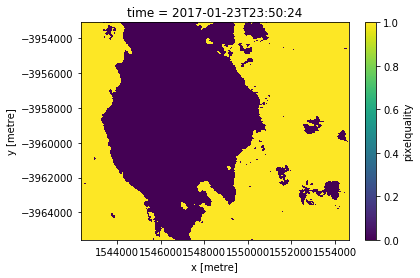

In [14]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud')
good_quality.plot();

In the next example, we create a mask with "good" `True` values only where there are no Fmask clouds **AND** no ACCA clouds in a pixel:

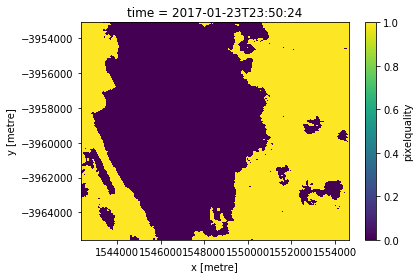

In [15]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud')
good_quality.plot();

In the next example, we create a mask with "good" `True` values only where there are no Fmask clouds **AND** no ACCA clouds **AND** no Fmask cloud shadows **AND** no ACCA cloud shadows in a pixel:

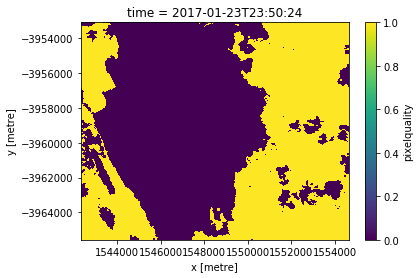

In [16]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow')
good_quality.plot();

In the next example, we create a mask with "good" `True` values only where there are no Fmask clouds **AND** no ACCA clouds **AND** no Fmask cloud shadows **AND** no ACCA cloud shadows **AND** no saturated values for any band:

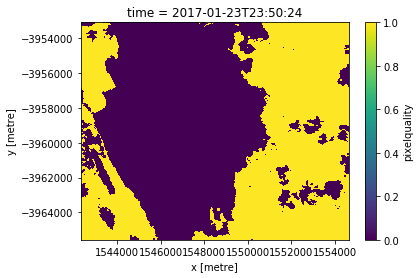

In [17]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False)
good_quality.plot();

Putting all the pieces together, we can create a mask with "good" `True` values only where there are no Fmask clouds **AND** no ACCA clouds **AND** no Fmask cloud shadows **AND** no ACCA cloud shadows **AND** no saturated values for any band **AND** where pixels have values for every band (i.e. 'contiguous' values). 

This final combined mask is a good starting point when working with Landsat data:

<xarray.DataArray 'pixelquality' (time: 1, y: 500, x: 492)>
array([[[ True,  True, ...,  True,  True],
        [ True, False, ...,  True,  True],
        ...,
        [ True,  True, ...,  True,  True],
        [ True,  True, ...,  True,  True]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-01-23T23:50:24
  * y        (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x        (x) float64 1.542e+06 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06


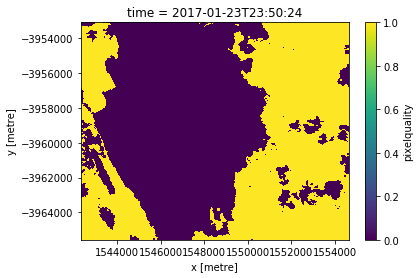

In [18]:
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
print(good_quality)
good_quality.plot();

## Apply the PQ mask
The code below will mask the specified pixels by setting their data points to NaN where the mask is `False`. In this example, this will mask out all pixels that are affected by cloud, cloud shadow, saturation, or any pixels that do not have data for every band:

In [19]:
# Apply the mask to preserve only the good data
ds_masked = ds.where(good_quality)
ds_masked

<xarray.Dataset>
Dimensions:          (time: 1, x: 492, y: 500)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-23T23:50:24
  * y                (y) float64 -3.953e+06 -3.953e+06 ... -3.966e+06 -3.966e+06
  * x                (x) float64 1.542e+06 1.542e+06 ... 1.555e+06 1.555e+06
Data variables:
    coastal_aerosol  (time, y, x) float64 579.0 420.0 nan ... 654.0 662.0 680.0
    blue             (time, y, x) float64 531.0 352.0 nan ... 707.0 702.0 729.0
    green            (time, y, x) float64 655.0 372.0 nan ... 969.0 974.0 987.0
    red              (time, y, x) float64 751.0 405.0 nan ... 1.345e+03 1.36e+03
    nir              (time, y, x) float64 2.439e+03 1.264e+03 ... 2.314e+03
    swir1            (time, y, x) float64 1.439e+03 594.0 ... 3.679e+03
    swir2            (time, y, x) float64 925.0 438.0 ... 2.251e+03 2.314e+03
Attributes:
    crs:      EPSG:3577

### Plot the PQ-masked Landsat data
Plot the data, and observe how all low-quality pixels (e.g. cloud) have been removed/masked out from the image:

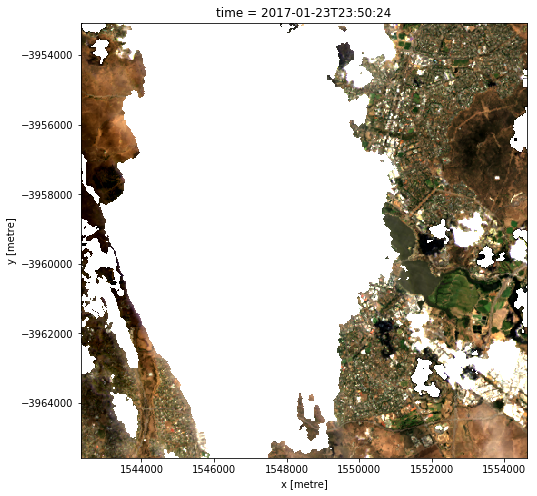

In [20]:
ds_masked[['red', 'green', 'blue']].isel(time=0).to_array().plot.imshow(robust=True, figsize=(8, 8))

## References
1. GA, 2015. *Pixel Quality (PQ25) Product Description* https://d28rz98at9flks.cloudfront.net/81942/Pixel_Quality_PQ25.PDF